In [85]:
import torch
from torchvision.transforms import Compose, ToTensor, Lambda, Resize, Grayscale
import cv2
import GRRNN as net
import numpy as np
import lmdb
import pickle
from matplotlib import pyplot as plt

In [86]:
MODEL_PATH = "model/output-model_epoch_49.pth"
MODE = "vertical"
DEVICE = "cuda"
NUM_WRITERS = 21

WRITER_IDEXES = "writer_save"
PATH_TO_LMDB = "/home/jovyan/data/HWR.2021-11-08/lmdb.hwr_40-1.0"
VAL_DATA = "/home/jovyan/data/HWR.2021-11-08/dataset_gt/pero.ceske_dopisy.ceske_kroniky.embed/final.2021-11-18/lines.filtered_max_width.val.550.shuf"

In [87]:

def get_epoch_model(epoch):
    model_path = f"model/output-model_epoch_{epoch}.pth"
    model = net.GrnnNet(1,num_classes=NUM_WRITERS,mode=MODE).to(DEVICE)
    
    model.load_state_dict(torch.load(model_path,map_location=DEVICE))
    model.eval()
    return model

In [88]:
def transform():
    return Compose([
        ToTensor(),
        Grayscale(),
        Lambda(lambda x: x / 255.),
        Resize((200, 50)),
    ])

In [90]:
with open(WRITER_IDEXES,'rb') as fp:
    id_map = pickle.load(fp)
    idx_tab = id_map

def get_id(writer):
    return idx_tab[writer]

In [91]:
lmdb_txn = lmdb.open(PATH_TO_LMDB, readonly=True).begin()

with open(VAL_DATA) as f:
    labels = np.array([line.rstrip().split(" ", 2) for line in f])

def loadImage(name):
    image = np.frombuffer(lmdb_txn.get(name.encode()), dtype=np.uint8)
    image = cv2.imdecode(image, 1)
    image = transform()(image)
    return image


inputs = np.array([loadImage(label[0]) for label in labels])
writers = np.array([get_id(label[1]) for label in labels])

batch_input = np.split(inputs, 100)
batch_writers = np.split(writers, 100)

num_failed = []

for epoch in range(50):
    model = get_epoch_model(epoch)
    results = []
    
    for i in range(len(batch_input)):
        input = torch.as_tensor(batch_input[i]).to(DEVICE).float()
        res = model(input).detach().cpu().numpy()
        max_index = np.argmax(res, axis=1)
        results = np.concatenate((results, max_index))
    
    
    invalid_count = 0
    for i in range(len(results)):
        if results[i] != writers[i]:
            invalid_count += 1

    num_failed.append(invalid_count)

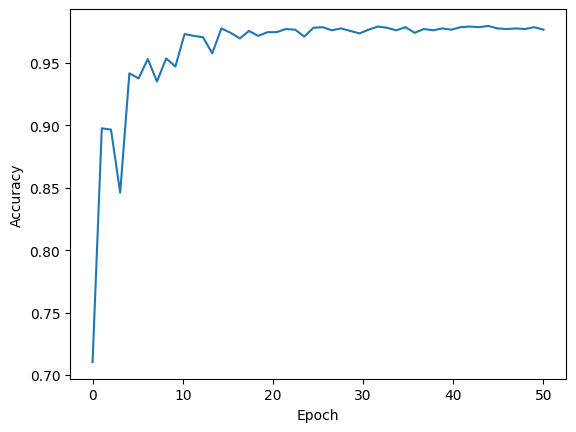

In [92]:
x = np.linspace(0, 50) 
y = 1 - (np.array(num_failed) / 2000)

plt.plot(x, y)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()